In [1]:
from functools import partial
from random import expovariate, sample

import os

import numpy as np
import simpy
import pandas as pd

import networkx as nx

from ns.packet.dist_generator import DistPacketGenerator
from ns.packet.trace_generator import TracePacketGenerator
from ns.packet.sink import PacketSink
from ns.switch.switch import SimplePacketSwitch
from ns.switch.switch import FairPacketSwitch
from ns.topos.fattree import build as build_fattree
from ns.topos.utils import generate_fib, generate_flows, read_topo

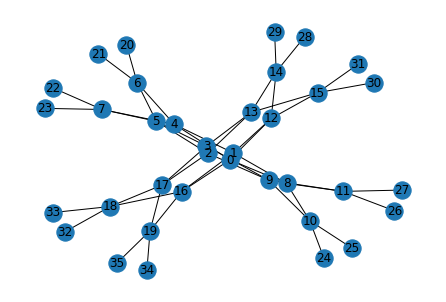

In [2]:
env = simpy.Environment()

mean_pkt_size=10
pir = 100000
buffer_size = 1000

k = 4
ft = build_fattree(k)

nx.draw(ft, with_labels=True)

In [3]:

hosts = set()
for n in ft.nodes():
    if ft.nodes[n]['type'] == 'host':
        hosts.add(n)

# Generate the flows by randomly choosing two hosts on the network
n_flows = 5
all_flows = generate_flows(ft, hosts, n_flows)
size_dist = partial(expovariate, 1.0 / mean_pkt_size)

for fid in all_flows:
    # Use the poisson process to specify packet generation.
    arr_dist = partial(expovariate, 1 + np.random.rand())
    pg = DistPacketGenerator(env,
                             f"Flow_{fid}",
                             arr_dist,
                             size_dist,
                             flow_id=fid)
    ps = PacketSink(env)

    all_flows[fid].pkt_gen = pg
    all_flows[fid].pkt_sink = ps

# This ns.py utility function generates the specific forwarding table that will dictate the specific path that the flow 
# will take to get from host to host.
ft = generate_fib(ft, all_flows)

# Generate priorities/weights for the classes. Currently trivial, all weights 1
n_classes_per_port = 4
weights = {c: 1 for c in range(n_classes_per_port)}

def flow_to_classes(f_id, n_id=0, fib=None):
    return (f_id + n_id + fib[f_id]) % n_classes_per_port


for node_id in ft.nodes():
    node = ft.nodes[node_id]
    flow_classes = partial(flow_to_classes,
                           n_id=node_id,
                           fib=node['flow_to_port'])
    
    # Here we make a packet switch to simulate the queueing.
    node['device'] = FairPacketSwitch(env,
                                      k,
                                      pir,
                                      buffer_size,
                                      weights,
                                      'DRR', # This can be DRR, WFQ, or SP; the DeepQueueNet paper does experiments with all 3.
                                      flow_classes,
                                      element_id=f"{node_id}")
    node['device'].demux.fib = node['flow_to_port']

# Map the forwarding table to specific ports where things will be forwarded to/from
for n in ft.nodes():
    node = ft.nodes[n]
    for port_number, next_hop in node['port_to_nexthop'].items():
        node['device'].ports[port_number].out = ft.nodes[next_hop]['device']


for flow_id, flow in all_flows.items():
    flow.pkt_gen.out = ft.nodes[flow.src]['device']
    ft.nodes[flow.dst]['device'].demux.ends[flow_id] = flow.pkt_sink

# Run the simulation for 1000 seconds
env.run(until=1000)

In [10]:
# TODO: Now, we need some-way of saving the simulated traces to a csv. This involves some processing of all_flows, example below:
for flow_id in all_flows.keys():
    print(f"Flow {flow_id}")
    # pkt_sizes = all_flows[flow_id].pkt_sink
    wait_times = all_flows[flow_id].pkt_sink.waits[flow_id]
    perhop_times = all_flows[flow_id].pkt_sink.perhop_times[flow_id]
    pkt_times = all_flows[flow_id].pkt_sink.packet_times[flow_id]
    arrivals = all_flows[flow_id].pkt_sink.arrivals[flow_id]
    # print(len(perhop_times), len(wait_times), len(pkt_times))
    # print(sum(perhop_times) / len(perhop_times))
    # print(sum(wait_times) / len(wait_times))
    # print(sum(pkt_times) / len(pkt_times))
    # pd.DataFrame(all_flows[flow_id])

a = all_flows[0].pkt_sink


Flow 0
Flow 1
Flow 2
Flow 3
Flow 4


In [27]:
flow.pkt_sink.packet_sizes[flow_id]

[11.115576023076358,
 0.5970447289478464,
 0.6858823869850198,
 2.4055471975714546,
 3.1797949054229493,
 2.288929670436205,
 24.872909081970054,
 0.9973342239273221,
 1.8300544189227068,
 16.628137421871045,
 0.26391975061222595,
 1.0960388728506119,
 0.9462308748450128,
 2.4865900799339915,
 10.38252839395955,
 9.429813610571856,
 3.1662695369950558,
 9.63454608348298,
 7.560162914972791,
 5.37014779210393,
 4.9863127403470004,
 7.727285246780348,
 9.4204038635101,
 2.828984125175652,
 3.3956185398150387,
 10.851044026394865,
 3.513523393363063,
 11.260367351133379,
 31.920562422165805,
 10.191854926057932,
 2.714904490264305,
 3.731776808351037,
 10.151253587033793,
 15.93449743229935,
 12.956326482689189,
 8.215446538490122,
 2.4981404065723614,
 3.463609402343109,
 11.770360019858574,
 6.3382813295939,
 38.468986102664616,
 1.236817603535368,
 0.9414159559459682,
 1.0722857298730515,
 1.3097827340669583,
 41.69629033774582,
 6.864984983192876,
 1.7815550188798652,
 0.5319665830452

In [24]:
def sink_to_df(flow_id, flow):
    perhop_times = flow.pkt_sink.perhop_times[flow_id]
    arrival_times = flow.pkt_sink.arrivals[flow_id] 
    pkt_sizes = flow.pkt_sink.packet_sizes[flow_id]
    data_dict = {
        'timestamp': [],
        'pkt_len': [],
        'cur_hub': [],
        'cur_port': [],
        'path': [],
        'etime': []
    }
        
    # Add the information for the rows of our df.
    for packet_hops, arrival_time in zip(perhop_times, arrival_times):
        a = sorted([(ts, dp) for dp, ts in packet_hops.items()])
        current_path = ''
        for i, (ts, dp) in enumerate(a):
            current_path += dp
            cur_hub, cur_port = tuple(dp.split('_'))
            etime = arrival_time if i == len(a) - 1 else a[i + 1][0]
            
            data_dict['pkt_len'].append(pkt_sizes[i])
            data_dict['timestamp'].append(ts)
            data_dict['cur_hub'].append(cur_hub)
            data_dict['cur_port'].append(cur_port)
            data_dict['path'].append(current_path)
            data_dict['etime'].append(etime)

            current_path += '-'

    # TODO: Get the priority from the flow somehow.
    data_dict['priority'] = [0] * len(data_dict['pkt_len'])
    
    # Make the data dict
    df = pd.DataFrame(data_dict)

    return df


In [25]:
flow_id, flow = next(iter(all_flows.items()))
df = sink_to_df(flow_id, flow)

In [26]:
df

,timestamp,pkt_len,cur_hub,cur_port,path,etime,priority
0,0.344223,11.115576,20,0,20_0,0.345112,0
1,0.345112,0.597045,6,0,20_0-6_0,0.346002,0
2,0.346002,0.685882,4,2,20_0-6_0-4_2,0.346891,0
3,0.346891,2.405547,0,3,20_0-6_0-4_2-0_3,0.347780,0
4,0.347780,3.179795,16,1,20_0-6_0-4_2-0_3-16_1,0.348669,0
...,...,...,...,...,...,...,...
7279,999.896808,0.597045,6,0,20_0-6_0,999.896818,0
7280,999.896818,0.685882,4,2,20_0-6_0-4_2,999.896828,0
7281,999.896828,2.405547,0,3,20_0-6_0-4_2-0_3,999.896838,0
7282,999.896838,3.179795,16,1,20_0-6_0-4_2-0_3-16_1,999.896847,0


In [17]:
wait_times

[0.010466918494385302,
 0.012880341872188339,
 0.002664840258634671,
 0.002592980139036527,
 0.005054255727690693,
 0.00023568783881877664,
 0.005455998470671908,
 0.0016392729660683614,
 0.0013352791590559576,
 0.014240151324379724,
 0.0019910555487960835,
 0.00024515289853077604,
 0.011594298747432674,
 0.00014197902709511823,
 0.005905221795458715,
 0.0018400499790356406,
 0.004999821051395514,
 0.003505820420842909,
 0.0005144944302166721,
 0.007849032348477891,
 0.0025674520535616807,
 0.007202076170525373,
 0.0028210880201271493,
 0.005992815388882633,
 0.0009238473295170024,
 0.003635477094523054,
 0.0004560442619911953,
 0.005694938457558862,
 0.004163995596073278,
 0.004273380770484891,
 0.0006874069073532496,
 0.004383088592980755,
 0.002698415118423725,
 0.00035225319800247235,
 0.009270174769383743,
 0.001868516272629961,
 0.015004606047028801,
 0.004867401082250922,
 0.0005048234685958164,
 0.017612965887252585,
 0.002725614472424809,
 0.01604313897424703,
 0.0164140672786

In [18]:
pkt_times

[0.23197586491414685,
 0.40711637247617527,
 0.5198716663130507,
 0.6915436046101631,
 0.8437867230186411,
 2.003732856964168,
 2.071955754943299,
 4.513978848914212,
 4.935144539208278,
 5.240752781446175,
 5.336129191253865,
 5.577291194602252,
 5.865555906263166,
 5.949972626273093,
 6.8569166136210615,
 7.2109266880629725,
 7.979430072876018,
 7.994705458567566,
 9.420227862229623,
 10.298038331254517,
 11.601412741291417,
 13.33496623259479,
 13.494769341570294,
 13.7131158048728,
 14.939887909747014,
 15.12165242765977,
 15.235708411449886,
 16.380363560214686,
 16.41414553245844,
 16.894352680863683,
 17.314646273089185,
 17.506707466265876,
 18.451114863911243,
 18.479760824962607,
 18.494885374281,
 18.656122665148207,
 18.830888313800514,
 19.511399306410475,
 19.80137832236534,
 20.530335601230053,
 21.84624333959113,
 22.10362326133068,
 22.313554085225256,
 22.54348195993488,
 23.035363726540403,
 23.26931492811478,
 23.783023217613337,
 23.95277420427419,
 24.524091866812

In [19]:
arrivals

[0.24244278340853215,
 0.4199967143483636,
 0.5225365065716854,
 0.6941365847491996,
 0.8488409787463318,
 2.0039685448029867,
 2.077411753413971,
 4.51561812188028,
 4.936479818367334,
 5.254992932770555,
 5.338120246802661,
 5.577536347500783,
 5.877150205010599,
 5.950114605300188,
 6.86282183541652,
 7.212766738042008,
 7.984429893927413,
 7.998211278988409,
 9.42074235665984,
 10.305887363602995,
 11.603980193344979,
 13.342168308765315,
 13.49759042959042,
 13.719108620261682,
 14.940811757076531,
 15.125287904754293,
 15.236164455711878,
 16.386058498672245,
 16.418309528054515,
 16.898626061634168,
 17.315333679996538,
 17.511090554858857,
 18.453813279029667,
 18.48011307816061,
 18.504155549050385,
 18.657991181420837,
 18.845892919847543,
 19.516266707492726,
 19.801883145833937,
 20.547948567117306,
 21.848968954063555,
 22.119666400304926,
 22.329968152503938,
 22.5516129716324,
 23.039532724310064,
 23.28514895735342,
 23.786580704798364,
 23.95377551938333,
 24.524343703

In [20]:
np.array(arrivals) - np.array(pkt_times)

array([0.01046692, 0.01288034, 0.00266484, ..., 0.00566169, 0.00244341,
       0.00611232])

In [22]:
wait_times

[0.010466918494385302,
 0.012880341872188339,
 0.002664840258634671,
 0.002592980139036527,
 0.005054255727690693,
 0.00023568783881877664,
 0.005455998470671908,
 0.0016392729660683614,
 0.0013352791590559576,
 0.014240151324379724,
 0.0019910555487960835,
 0.00024515289853077604,
 0.011594298747432674,
 0.00014197902709511823,
 0.005905221795458715,
 0.0018400499790356406,
 0.004999821051395514,
 0.003505820420842909,
 0.0005144944302166721,
 0.007849032348477891,
 0.0025674520535616807,
 0.007202076170525373,
 0.0028210880201271493,
 0.005992815388882633,
 0.0009238473295170024,
 0.003635477094523054,
 0.0004560442619911953,
 0.005694938457558862,
 0.004163995596073278,
 0.004273380770484891,
 0.0006874069073532496,
 0.004383088592980755,
 0.002698415118423725,
 0.00035225319800247235,
 0.009270174769383743,
 0.001868516272629961,
 0.015004606047028801,
 0.004867401082250922,
 0.0005048234685958164,
 0.017612965887252585,
 0.002725614472424809,
 0.01604313897424703,
 0.0164140672786